In [ ]:
# Windows local host
#filepath = 'C:/Users/Alber/PHB009/PHB009/dataset/model/combined_data.csv'
# Google Colab
filepath = '/content/drive/MyDrive/PHB009/dataset/model/combined_data.csv'
save_to = '/content/drive/MyDrive/PHB009/dataset/model/LSTM.csv'

In [ ]:
# Training and Testing split
train_end = '2022-12-01'
test_start = '2022-12-02'

# Period for comparison and RMSE calculation (start needs to be test + 30 days)
start_date = '2023-01-01'
end_date = '2023-06-01'

## Long Short-Term Memory (LSTM) Networks:

In this code, we first preprocess the data by selecting the desired columns, setting the Date column as the index, and normalizing the data using MinMaxScaler. We then split the data into training and testing sets. The create_sequences function is used to create input sequences and labels for the LSTM model.

Next, we build and train the LSTM model using the training data. We use the EarlyStopping callback to prevent overfitting by monitoring the validation loss. After training, we generate predictions for both the training and testing sets.

Finally, we inverse transform the predictions and actual values to their original scale using the MinMaxScaler. We plot the training and testing predictions along with the actual values to visualize the forecasted energy prices.

Please note that you may need to adjust the architecture, hyperparameters, and preprocessing steps based on your specific requirements and dataset characteristics.

In [ ]:
import pandas as pd

# Read the data into a DataFrame (replace 'your_data.csv' with your actual file)
data_df = pd.read_csv(filepath, parse_dates=['Date'])

columns_to_drop =  ['Open', 'High', 'Low', 'Close', 'BOMBEO', 'BRENT', 'CARBON', 'CICLOCOMBINADO', 'COGENERACION', 'EOLICA', 'HIDRAULICA', 'NUCLEAR', 'SOLAR', 'TTF']  # Replace with your column names
data_df.drop(columns=columns_to_drop, inplace=True)
data_df.fillna(method='ffill', inplace=True)
data_df.fillna(method='bfill', inplace=True)

# Read the CSV files into dataframes
impact_df = pd.read_csv('/content/drive/MyDrive/PHB009/dataset/model/AggregatedImpactOpenAI.csv', parse_dates=['Date'])

# Convert 'Date' columns to datetime format
data_df['Date'] = pd.to_datetime(data_df['Date'])
impact_df['Date'] = pd.to_datetime(impact_df['Date'])

# Left join dataframes based on 'Date'
result_df = data_df.merge(impact_df, on='Date', how='left')

# Fill missing values with 0 for the 'df_impact' columns
impact_columns = ['Impact_long', 'Impact_short']
result_df[impact_columns] = result_df[impact_columns].fillna(0)

result_df

,Date,Price,GasPrice,Demand,Non-renewable,Renewable,Renewable%,IBEX35,MIBGAS,OMIP,Impact_long,Impact_short
0,2018-01-01,25.575652,21.81,20545.034,13246.167,52707.752,79.916027,10079.099609,21.81,61.85,0.000000,-0.575000
1,2018-01-02,40.395000,22.51,18436.677,20002.151,63514.750,76.050176,10079.099609,22.51,61.85,0.000000,-0.560000
2,2018-01-03,45.659167,20.40,27336.476,13118.374,64639.179,83.129132,10116.000000,20.40,61.85,0.000000,-0.540000
3,2018-01-04,45.440833,19.01,24369.628,15972.084,75027.418,82.448163,10314.400391,19.01,61.85,0.000000,-0.525000
4,2018-01-05,44.158750,19.78,6050.885,13230.971,70900.792,84.273513,10411.400391,19.78,61.85,0.000000,-0.510000
...,...,...,...,...,...,...,...,...,...,...,...,...
1973,2023-05-28,85.040833,24.95,11943.874,8920.884,49018.014,84.602945,9191.100000,24.95,179.72,-0.274375,-0.650667
1974,2023-05-29,95.328750,26.05,11057.423,9343.901,64469.725,87.341225,9180.100000,26.05,179.72,-0.265625,-0.630667
1975,2023-05-30,93.355833,25.59,9792.152,8348.557,59350.614,87.668155,9167.500000,25.59,179.72,-0.258125,-0.612000
1976,2023-05-31,88.555833,25.49,7731.300,11392.400,68339.000,85.711526,9050.200000,25.49,179.72,-0.250000,-0.594000


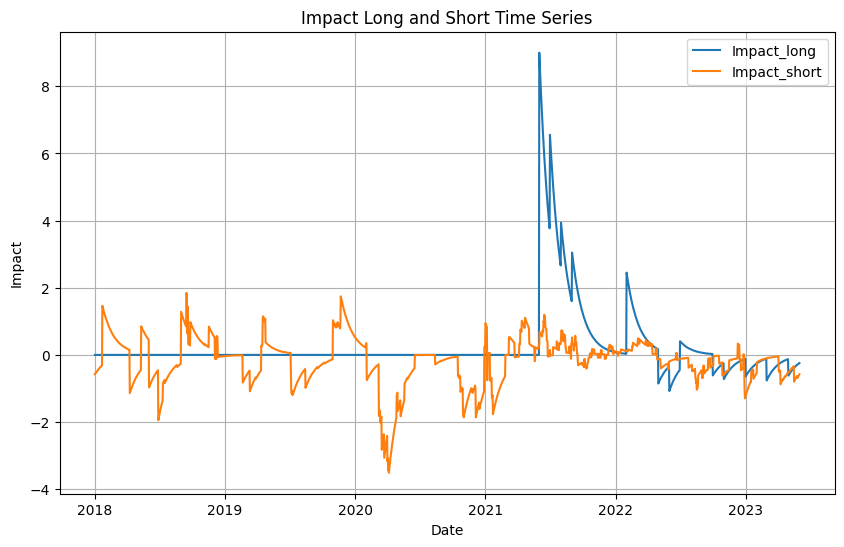

In [ ]:
import matplotlib.pyplot as plt

# Plot the time series for 'Impact_long' and 'Impact_short'
plt.figure(figsize=(10, 6))
plt.plot(result_df['Date'], result_df['Impact_long'], label='Impact_long')
plt.plot(result_df['Date'], result_df['Impact_short'], label='Impact_short')
plt.xlabel('Date')
plt.ylabel('Impact')
plt.title('Impact Long and Short Time Series')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
!pip install scikeras

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from scikeras.wrappers import KerasRegressor
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Select the relevant columns for the LSTM model
columns = result_df.columns.tolist()
lstm_data = result_df[columns].copy()

# Set the 'Date' column as the index
lstm_data.set_index('Date', inplace=True)

# Define the date range for training (2018-01-01 to 2022-12-31)
# Divide the data into train and test sets
train_data = lstm_data.loc[(lstm_data.index <= train_end)]

# Define the date range for testing (2023-01-01 to 2023-06-01)
test_data = lstm_data.loc[(lstm_data.index >= test_start)]

# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Define the number of time steps and features
n_steps = 30  # Number of time steps to consider
n_features = lstm_data.shape[1] - 1  # Number of features (excluding the date column)

# Prepare the data for LSTM training
X_train, y_train = [], []
for i in range(n_steps, len(train_data_scaled)):
    X_train.append(train_data_scaled[i - n_steps:i, 1:])  # Exclude the date and price columns
    y_train.append(train_data_scaled[i, 1])  # Price column
X_train, y_train = np.array(X_train), np.array(y_train)

# Define the function to create the LSTM model
def create_model(units):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

best_model = create_model(units=50)
best_epochs = 20
best_batch_size = 64

# Train the LSTM model with the best hyperparameters
best_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Prepare the data for LSTM testing
X_test, y_test = [], []
for i in range(len(test_data_scaled) - n_steps + 1):
    X_test.append(test_data_scaled[i:i + n_steps, 1:])  # Exclude the date and price columns
X_test = np.array(X_test)

# Make predictions using the trained LSTM model
forecast_scaled = best_model.predict(X_test)

# Reshape forecast_scaled to match the expected shape
n_samples = len(forecast_scaled)
forecast_reshaped = np.full((n_samples, n_features + 1), np.nan)
forecast_reshaped[:, 1] = forecast_scaled.flatten()

# Perform inverse scaling and extract the forecasted price
forecast = scaler.inverse_transform(forecast_reshaped)[:, 1]

# Create a DataFrame for the forecasted values
forecast_index = pd.date_range(start=test_start, periods=len(forecast), freq='D')
forecast_index = forecast_index.shift(n_steps, freq='D')  # Shift the index by n_steps days
forecast_data = pd.DataFrame({'Date': forecast_index, 'Forecasted Price': forecast})


5/5 [==============================] - 0s 6ms/step


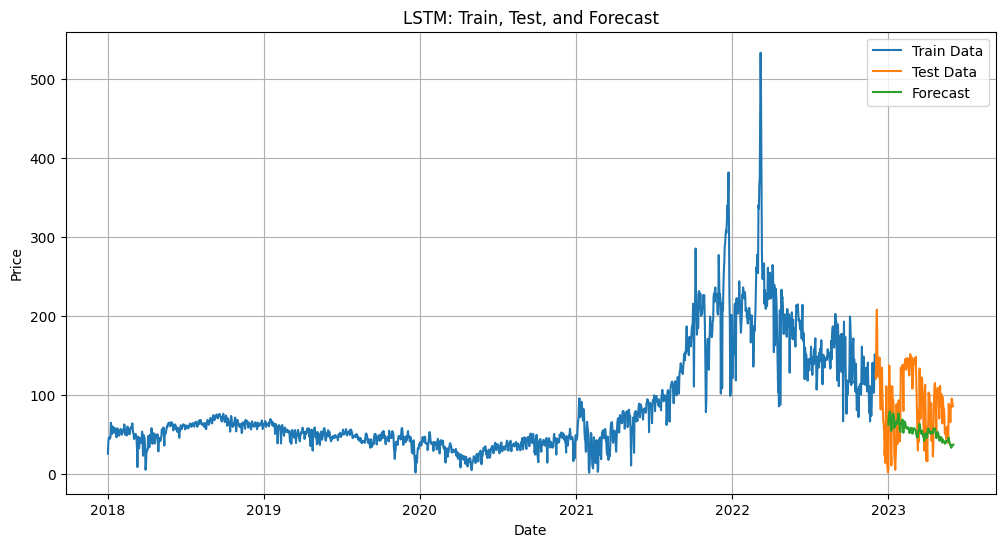

In [ ]:
import matplotlib.pyplot as plt

test_data_subset = test_data[test_data.index >= test_start]

# Convert the train and test data to Matplotlib format
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Price'], label='Train Data')
plt.plot(test_data_subset.index, test_data_subset['Price'], label='Test Data')
plt.plot(forecast_data['Date'], forecast_data['Forecasted Price'], label='Forecast')
plt.title('LSTM: Train, Test, and Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

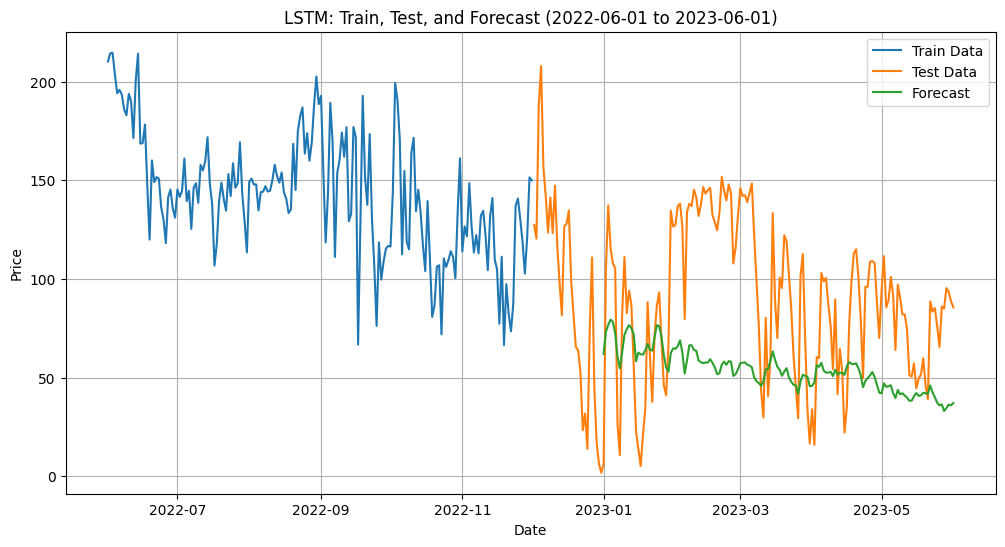

In [ ]:
# Filter data for the desired period
graph_start_date = '2022-06-01'
train_data_filtered = train_data[(train_data.index >= graph_start_date) & (train_data.index <= end_date)]
test_data_filtered = test_data[(test_data.index >= graph_start_date) & (test_data.index <= end_date)]
forecast_filtered = forecast_data[(forecast_data['Date'] >= graph_start_date) & (forecast_data['Date'] <= end_date)]

# Plot the filtered train, test, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data_filtered.index, train_data_filtered['Price'], label='Train Data')
plt.plot(test_data_filtered.index, test_data_filtered['Price'], label='Test Data')
plt.plot(forecast_filtered['Date'], forecast_filtered['Forecasted Price'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LSTM: Train, Test, and Forecast (2022-06-01 to 2023-06-01)')
plt.legend()
plt.grid(True)
plt.show()

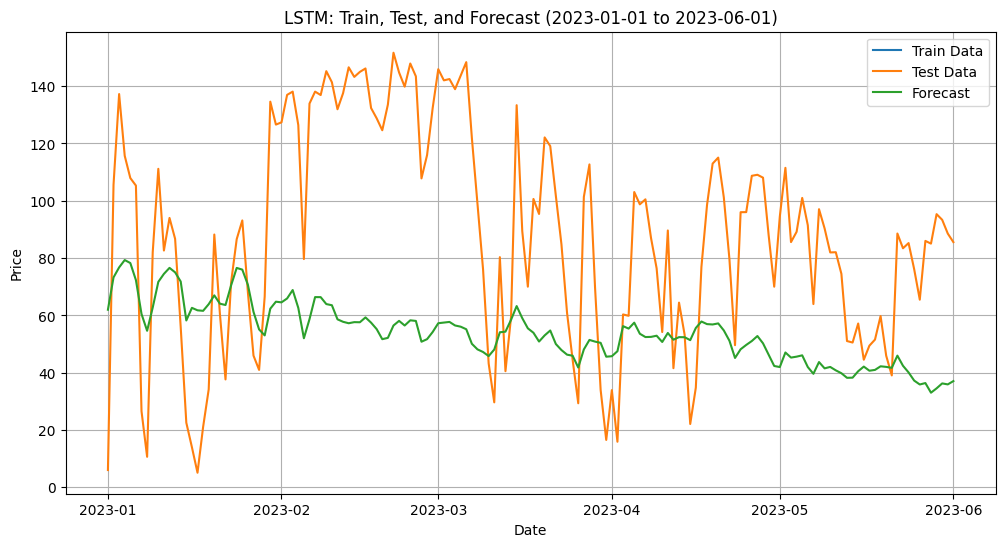

In [ ]:
# Filter data for the desired period
train_data_filtered = train_data[(train_data.index >= start_date) & (train_data.index <= end_date)]
test_data_filtered = test_data[(test_data.index >= start_date) & (test_data.index <= end_date)]
forecast_filtered = forecast_data[(forecast_data['Date'] >= start_date) & (forecast_data['Date'] <= end_date)]

# Plot the filtered train, test, and forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data_filtered.index, train_data_filtered['Price'], label='Train Data')
plt.plot(test_data_filtered.index, test_data_filtered['Price'], label='Test Data')
plt.plot(forecast_filtered['Date'], forecast_filtered['Forecasted Price'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('LSTM: Train, Test, and Forecast (2023-01-01 to 2023-06-01)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

future_periods = 152

# Copy the forecast_filtered DataFrame to avoid modifying the original data
forecast_filtered_copy = forecast_filtered.copy()

# Assign the 'y' values from test_data_filtered to the copy
forecast_filtered_copy.loc[:, 'Price'] = test_data_filtered['Price'].values

# Extract actual values
actual_values = forecast_filtered_copy['Price'].values

# Extract predicted values
predicted_values = forecast_filtered_copy['Forecasted Price'].values[-future_periods:]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Root Mean Squared Error (RMSE): 50.12


In [ ]:
# Rename the columns
forecast_filtered_copy.rename(columns={'Forecasted Price':'Prediction'}, inplace=True)

In [ ]:
# Reset the index
forecast_filtered_copy.reset_index(drop=True, inplace=True)
forecast_filtered_copy[['Date','Price','Prediction']]

,Date,Price,Prediction
0,2023-01-01,6.034583,61.973368
1,2023-01-02,105.573333,73.260002
2,2023-01-03,137.238333,76.742152
3,2023-01-04,115.684167,79.314893
4,2023-01-05,107.924583,78.268682
...,...,...,...
147,2023-05-28,85.040833,33.021857
148,2023-05-29,95.328750,34.536503
149,2023-05-30,93.355833,36.264045
150,2023-05-31,88.555833,35.918015


In [ ]:
forecast_filtered_copy[['Date','Price','Prediction']].to_csv('/content/drive/MyDrive/PHB009/dataset/model/results/1DAILSTMResults.csv')

## Interactive Graphs

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Convert the train and test data to Plotly format
train_trace = go.Scatter(x=train_data.index, y=train_data['Price'], name='Train Data')
test_trace = go.Scatter(x=test_data.index, y=test_data['Price'], name='Test Data')
forecast_trace = go.Scatter(x=forecast_data['Date'], y=forecast_data['Forecasted Price'], name='Forecasted Price')

# Create the figure layout
layout = go.Layout(
    title='LSTM Forecast: Actual vs Forecasted Price',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h', x=0.1, y=-0.2),
    template='plotly_white'
)

# Create the figure object
fig = go.Figure(data=[train_trace, test_trace, forecast_trace], layout=layout)

# Show the interactive graph
pio.show(fig)

In [ ]:
import plotly.graph_objects as go
import plotly.io as pio

# Filter data for the desired period
train_data_filtered = train_data[(train_data.index >= start_date) & (train_data.index <= end_date)]
test_data_filtered = test_data[(test_data.index >= start_date) & (test_data.index <= end_date)]
forecast_data_filtered = forecast_data[(forecast_data['Date'] >= start_date) & (forecast_data['Date'] <= end_date)]

# Convert the filtered train and test data to Plotly format
train_trace = go.Scatter(x=train_data_filtered.index, y=train_data_filtered['Price'], name='Train')
test_trace = go.Scatter(x=test_data_filtered.index, y=test_data_filtered['Price'], name='Test')
forecast_trace = go.Scatter(x=forecast_data_filtered['Date'], y=forecast_data_filtered['Forecasted Price'], name='Forecasted Price')

# Create the figure layout
layout = go.Layout(
    title='LSTM Forecast: Actual vs Forecasted Price (2022-06-01 to 2023-06-01)',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h', x=0.1, y=-0.2),
    template='plotly_white'
)

# Create the figure object
fig = go.Figure(data=[train_trace, test_trace, forecast_trace], layout=layout)

# Show the interactive graph
pio.show(fig)

# Projection 2023-06-01 to 2023-08-16 with no extra data

Retrain the model with all the previous dates and forecast for the validation period

In [ ]:
# Define the date range for training (2018-01-01 to 2022-12-31)
train_data = lstm_data.loc[(lstm_data.index <= '2023-05-31')]


# Normalize the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)

# Define the number of time steps and features
n_steps = 30  # Number of time steps to consider
n_features = lstm_data.shape[1] - 1  # Number of features (excluding the date column)

# Prepare the data for LSTM training
X_train, y_train = [], []
for i in range(n_steps, len(train_data_scaled)):
    X_train.append(train_data_scaled[i - n_steps:i, 1:])  # Exclude the date and price columns
    y_train.append(train_data_scaled[i, 1])  # Price column
X_train, y_train = np.array(X_train), np.array(y_train)

# Define the function to create the LSTM model
def create_model(units):
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the KerasRegressor wrapper for GridSearchCV
best_model = create_model(units=50)
best_epochs = 20
best_batch_size = 64

# Train the LSTM model with the best hyperparameters
best_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

In [ ]:
# Define the number of additional time steps for the extended forecast
n_additional_steps = 77
n_features = lstm_data.shape[1] - 1

# Get the last n_steps data points from the test set as initial input
X_forecast = train_data_scaled[-n_steps:, 1:]

# Initialize a list to store forecasted prices
forecasted_prices = []

# Forecast for the desired number of time steps
for _ in range(n_additional_steps):
    # Reshape the input data for LSTM
    X_forecast_reshaped = X_forecast.reshape(1, n_steps, n_features)

    # Make a prediction using the trained LSTM model
    forecast_scaled = best_model.predict(X_forecast_reshaped)

    # Reshape forecast_scaled to match the expected shape
    n_samples = len(forecast_scaled)
    forecast_reshaped = np.full((n_samples, n_features+1), np.nan)
    forecast_reshaped[:, 1] = forecast_scaled.flatten()

    # Perform inverse scaling and extract the forecasted price
    forecast = scaler.inverse_transform(forecast_reshaped)[:,1]

    # Append the forecasted price to the list
    forecasted_prices.append(forecast[0])

    # Update X_forecast for the next iteration by shifting the values and adding the new forecasted value
    X_forecast = np.roll(X_forecast, -1, axis=0)
    X_forecast[-1, 1] = forecast_scaled  # Update the last value in the sequence
    print(X_forecast[-1, 1])

# Create a DataFrame for the extended forecasted prices
forecasted_index = pd.date_range(start='2023-06-01', periods=n_additional_steps, freq='D')

In [ ]:
# Specify the directory where your result files are stored
file_path = '/content/drive/MyDrive/PHB009/dataset/precio electricidad OMIE/Jun-Ago2023/energyPricesValidation.csv'
df = pd.read_csv(file_path)

extended_forecast_data = pd.DataFrame({'Date': forecasted_index, 'Projection': forecasted_prices})

# Use the 'Date' column as the index
df.set_index('Date', inplace=True)
extended_forecast_data.set_index('Date', inplace=True)

# Ensure the index is in datetime format
df.index = pd.to_datetime(df.index)
extended_forecast_data.index = pd.to_datetime(df.index)

merged_df = df.merge(extended_forecast_data, left_index=True, right_index=True)

import plotly.graph_objects as go
import plotly.io as pio

# Convert the train and test data to Plotly format
actuals = go.Scatter(x=merged_df.index, y=merged_df['Price'], name='Actual Price')
projections = go.Scatter(x=merged_df.index, y=merged_df['Projection'], name='Projected Price')

# Create the figure layout
layout = go.Layout(
    title='LSTM Forecast: Actual vs Projected Price',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price'),
    legend=dict(orientation='h', x=0.1, y=-0.2),
    template='plotly_white'
)

# Create the figure object
fig = go.Figure(data=[actuals, projections], layout=layout)

# Show the interactive graph
pio.show(fig)

merged_df[['Price','Projection']].to_csv('/content/drive/MyDrive/PHB009/dataset/model/projections/1DAILSTMResults.csv')